# Immigration: Counting H2A certifications issued per year

The H-2A visa is for temporary employment of foreign workers in agriculture. For a worker to get a visa, their employer must get *certification* for the job. The Office of Foreign Labor Certification releases data on how many jobs are *certified* each year, not the number of visas issued. (As the chart below notes, the number of visas is roughly 80% of the number of jobs certified, because some employers don't actually hire people for the certified roles, and some foreign workers take two certified jobs.)

Souce: [Office of Foreign Labor Certification](https://www.dol.gov/agencies/eta/foreign-labor/performance)

Reference chart taken from [here](https://www.ers.usda.gov/data-products/chart-gallery/gallery/chart-detail/?chartId=86844):

![h2a by state](image/h2apositions.png)

THINGS WE HAVE ALREADY DONE:
* Download 2014-2024 data as individual spreadsheets from Source: [Office of Foreign Labor Certification](https://www.dol.gov/agencies/eta/foreign-labor/performance)
* Using Python, insert contents of each of the 11 spreadsheets into a different table of a SQL database, for fast querying
* Rename some columns to reflect the fact that OFLC naming conventions have changed over time.

TO OBTAIN DATA FOR THIS GRAPHIC WE:
* Identify the subset of columns we need from the database
* Using the Python/SQL library, write a SQL query to pull just these columns
* Return the results of that query as a dataframe

But first: 
* Let's check that we're making the correct calculations with this data by trying to reproduce the numbers in the graphic above, produced by US Department of Agriculture.
* To run the workbook: Download the SQLite database [from here](https://storage.googleapis.com/datanode/h2a_visas/data/db/H2A_data.db)

Columns we need for graphic:
```
DECISION_DATE
TOTAL_WORKERS_H2A_CERTIFIED
EMPLOYER_STATE
```

----

In [4]:
import sqlite3
import pandas as pd

# Define path to our db
db = 'db/H2A_data.db'

First, to verify we know how to use the data: let's count the number of workers by *fiscal year* and check it fits with the chart made by Department of Agriculture. Once our numbers match, we have enough confidence to make our own calculations by *calendar year*.

Having looked at the data in spreadsheet form, we can identify one cause for double counting that we need to eliminate: When a primary contractor obtains H2A visas for workers who are then subcontracted to other companies, the spreadsheet has an entry for the **primary contractor and all subcontractors**, even though these are the same workers.

So when we calculate total visas approved by year and state, we should only count the primary contractors and not include subcontractors.

In [28]:
## Retrieve from SQL database the number of H2A work permits certified 
# by *fiscal* year and state,
## only including primary contractors
## and excluding "Joint Employers" from 2014-16 data

def get_workers_by_state_fyear2(db_path):
    with sqlite3.connect(db_path) as conn:
        tables = pd.read_sql_query(
            "SELECT name FROM sqlite_master WHERE type='table'", conn
        )
        
        union_parts = []
        for table in tables['name']:
            # Explanation of SQL CASE QUERY:
            # First we need to check if column "PRIMARY/SUB" exists in a table.
            # If it exists, we need to check each row to see if the value is "PRI"
            union_parts.append(f"""
                SELECT 
                    FY as year,
                    EMPLOYER_STATE,
                    CASE 
                        WHEN EXISTS (
                            SELECT 1 FROM pragma_table_info('{table}') 
                            WHERE name = 'PRIMARY/SUB'
                        )
                        AND "PRIMARY/SUB" = 'PRI' THEN TOTAL_WORKERS_H2A_CERTIFIED
                        WHEN NOT EXISTS (
                            SELECT 1 FROM pragma_table_info('{table}') 
                            WHERE name = 'PRIMARY/SUB'
                        )
                        THEN TOTAL_WORKERS_H2A_CERTIFIED
                        ELSE 0
                    END as TOTAL_WORKERS_H2A_CERTIFIED
                FROM {table}
            """)
        
        query = f"""
        WITH all_data AS (
            {' UNION ALL '.join(union_parts)}
        )
        SELECT 
            year,
            EMPLOYER_STATE,
            SUM(TOTAL_WORKERS_H2A_CERTIFIED) as total_workers,
            COUNT(*) as number_of_applications
        FROM all_data
        GROUP BY year, EMPLOYER_STATE
        ORDER BY year, EMPLOYER_STATE;
        """
        
        return pd.read_sql_query(query, conn)

In [ ]:
df = get_workers_by_state_fyear2(db)

In [29]:
df.head()

,year,EMPLOYER_STATE,total_workers,number_of_applications
0,FY2014,AK,15.0,1
1,FY2014,AL,626.0,41
2,FY2014,AR,3343.0,182
3,FY2014,AZ,1535.0,40
4,FY2014,CA,7372.0,300


In [30]:
# Group by state, find the total number of workers.
## We will then look to see if this matches with the USDA bar chart
df.groupby('year')['total_workers'].sum()

year
FY2014    136822.0
FY2015    162720.0
FY2016    165741.0
FY2017    200049.0
FY2018    242762.0
FY2019    257667.0
FY2020    275430.0
FY2021    317619.0
FY2022    371619.0
FY2023    378513.0
FY2024    384865.0
Name: total_workers, dtype: float64

### Assessment:

We have the correct figures from 2017-2024, but the numbers for 2014-2016 are too high. We must have some double counts in the data somewhere.

**Solution**:

After browsing the DB we found that in data from earlier years, we need to not count columns where the value of `ORGANIZATION_FLAG` is `Association - Joint Employer (H-2A Only)` to avoid double counts. (This is effectively the equivalent of PRIMARY/SUB flag in later datasets.)

In [31]:
## Retrieve from SQL database the number of H2A work permits certified 
# by *fiscal* year and state,
## only including primary contractors
## and excluding "Joint Employers" from 2014-16 data

def get_workers_by_state_fyear(db_path):
   with sqlite3.connect(db_path) as conn:
       tables = pd.read_sql_query(
           "SELECT name FROM sqlite_master WHERE type='table'", conn
       )
       
       union_parts = []
       for table in tables['name']:
           columns = pd.read_sql_query(f"PRAGMA table_info({table})", conn)
           has_primary_sub = 'PRIMARY/SUB' in columns['name'].values
           has_org_flag = 'ORGANIZATION_FLAG' in columns['name'].values
           
           where_clause = ""
           if has_primary_sub:
               where_clause = "WHERE \"PRIMARY/SUB\" = 'PRI'"
           elif has_org_flag:
               where_clause = "WHERE ORGANIZATION_FLAG != 'Association - Joint Employer (H-2A Only)'"
           
           union_parts.append(f"""
               SELECT 
                   FY as year,
                   EMPLOYER_STATE,
                   TOTAL_WORKERS_H2A_CERTIFIED
               FROM {table}
               {where_clause}
           """)
       
       query = f"""
       WITH all_data AS (
           {' UNION ALL '.join(union_parts)}
       )
       SELECT 
           year,
           EMPLOYER_STATE,
           SUM(TOTAL_WORKERS_H2A_CERTIFIED) as total_workers,
           COUNT(*) as number_of_applications
       FROM all_data
       GROUP BY year, EMPLOYER_STATE
       ORDER BY year, EMPLOYER_STATE;
       """
       
       return pd.read_sql_query(query, conn)

In [9]:
df2 = get_workers_by_state_fyear(db)

In [10]:
df2.groupby('year')['total_workers'].sum()

year
FY2014    116078.0
FY2015    140308.0
FY2016    165741.0
FY2017    200049.0
FY2018    242762.0
FY2019    257667.0
FY2020    275430.0
FY2021    317619.0
FY2022    371619.0
FY2023    378513.0
FY2024    384865.0
Name: total_workers, dtype: float64

VERIFICATION CHECK PASSED! 

Our yearly numbers now agree with the original bar chart from the Economic Research Service,
which shows data by fiscal year up to 2023.

Now we have enough understanding of the data to make our own calculations by calendar year not fiscal year, and including 2024 data.

In [11]:
## Retrieve from SQL database the number of H2A work permits certified 
# by *calendar* year and state,
## only including primary contractors
## and excluding "Joint Employers" from 2014-16 data

def get_workers_by_year_and_state(db_path):
   with sqlite3.connect(db_path) as conn:
       tables = pd.read_sql_query(
           "SELECT name FROM sqlite_master WHERE type='table'", conn
       )
       
       union_parts = []
       for table in tables['name']:
           columns = pd.read_sql_query(f"PRAGMA table_info({table})", conn)
           has_primary_sub = 'PRIMARY/SUB' in columns['name'].values
           has_org_flag = 'ORGANIZATION_FLAG' in columns['name'].values
           
           where_clause = ""
           if has_primary_sub:
               where_clause = "WHERE \"PRIMARY/SUB\" = 'PRI'"
           elif has_org_flag:
               where_clause = "WHERE ORGANIZATION_FLAG != 'Association - Joint Employer (H-2A Only)'"
           
           union_parts.append(f"""
               SELECT 
                    strftime('%Y', DECISION_DATE) as year,
                   EMPLOYER_STATE,
                   TOTAL_WORKERS_H2A_CERTIFIED
               FROM {table}
               {where_clause}
           """)
       
       query = f"""
       WITH all_data AS (
           {' UNION ALL '.join(union_parts)}
       )
       SELECT 
           year,
           EMPLOYER_STATE,
           SUM(TOTAL_WORKERS_H2A_CERTIFIED) as total_workers,
           COUNT(*) as number_of_applications
       FROM all_data
       GROUP BY year, EMPLOYER_STATE
       ORDER BY year, EMPLOYER_STATE;
       """
       
       return pd.read_sql_query(query, conn)

In [12]:
dfs = get_workers_by_year_and_state(db)

In [13]:
dfs.head()

,year,EMPLOYER_STATE,total_workers,number_of_applications
0,2013,AL,298.0,13
1,2013,AR,204.0,30
2,2013,AZ,748.0,8
3,2013,CA,2584.0,73
4,2013,CO,290.0,63


To make the stacked bar chart, we first pivot the data so that there is one row per year with all states:

In [15]:
dfs.pivot_table(index='year',columns='EMPLOYER_STATE',values='total_workers').fillna(0)

EMPLOYER_STATE,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,TX,UT,VA,VI,VT,WA,WI,WV,WY,nan
year,,,,,,,,,,,,,,,,,,,,,
2013,0.0,298.0,204.0,748.0,2584.0,290.0,5.0,0.0,0.0,6789.0,...,276.0,326.0,171.0,0.0,7.0,249.0,2.0,0.0,157.0,0.0
2014,15.0,639.0,3408.0,1590.0,7504.0,1746.0,403.0,0.0,36.0,19619.0,...,2376.0,785.0,3397.0,0.0,511.0,8593.0,150.0,37.0,407.0,209.0
2015,15.0,597.0,4067.0,2298.0,10183.0,1715.0,478.0,0.0,42.0,23319.0,...,2623.0,892.0,3521.0,0.0,492.0,12217.0,202.0,72.0,383.0,261.0
2016,17.0,745.0,3978.0,3524.0,13192.0,1996.0,335.0,0.0,48.0,32870.0,...,3058.0,1074.0,3133.0,0.0,524.0,14948.0,407.0,96.0,350.0,203.0
2017,22.0,994.0,4332.0,5245.0,16122.0,2226.0,424.0,0.0,175.0,40940.0,...,3519.0,798.0,3292.0,0.0,537.0,18810.0,505.0,144.0,346.0,197.0
2018,33.0,1175.0,4408.0,5570.0,20499.0,2891.0,592.0,0.0,127.0,53210.0,...,4440.0,1173.0,3507.0,0.0,540.0,22666.0,719.0,215.0,350.0,149.0
2019,38.0,1376.0,5096.0,6365.0,23641.0,3109.0,761.0,0.0,119.0,56383.0,...,6848.0,1171.0,3024.0,0.0,508.0,27099.0,1015.0,203.0,370.0,192.0
2020,20.0,1902.0,5884.0,4961.0,29370.0,3101.0,893.0,0.0,141.0,61441.0,...,7981.0,1161.0,3062.0,0.0,525.0,27021.0,1112.0,235.0,404.0,191.0
2021,54.0,2408.0,5707.0,7014.0,37426.0,3361.0,898.0,0.0,143.0,70603.0,...,9088.0,1620.0,3331.0,3.0,517.0,28232.0,1386.0,238.0,505.0,385.0


In [17]:
import matplotlib.pyplot as plt
import afp_style as style
plt.style.use('https://storage.googleapis.com/datanode/afpchart.mplstyle')

In [32]:
# Save the pivot table above to a variable
piv = dfs.pivot_table(index='year',columns='EMPLOYER_STATE',values='total_workers').fillna(0)


<Axes: xlabel='year'>

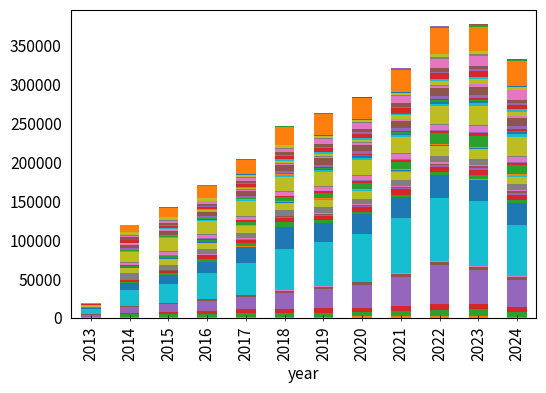

In [33]:
piv.plot(kind='bar',stacked=True,legend=False)

This bar chart has too many groups to be readable...

Instead let's find the top 5 states and give each of them a group, then make another group for all other states combined.

In [34]:
# Find top employer states in 2023
dfs[dfs.year=='2023'].sort_values(by='total_workers',ascending=False).head(5)

,year,EMPLOYER_STATE,total_workers,number_of_applications
515,2023,FL,83021.0,1510
511,2023,CA,44328.0,1074
554,2023,WA,31421.0,406
516,2023,GA,27239.0,592
533,2023,NC,24275.0,607


In [20]:
top_employers = ['FL','CA','WA','GA','NC']

In [21]:
# Get a dataframe of top 5 states
piv[top_employers].reset_index()


EMPLOYER_STATE,year,FL,CA,WA,GA,NC
0,2013,6789.0,2584.0,249.0,1594.0,0.0
1,2014,19619.0,7504.0,8593.0,9163.0,12932.0
2,2015,23319.0,10183.0,12217.0,12030.0,16681.0
3,2016,32870.0,13192.0,14948.0,15158.0,17379.0
4,2017,40940.0,16122.0,18810.0,20786.0,19479.0
5,2018,53210.0,20499.0,22666.0,27656.0,18947.0
6,2019,56383.0,23641.0,27099.0,24522.0,18891.0
7,2020,61441.0,29370.0,27021.0,24966.0,19970.0
8,2021,70603.0,37426.0,28232.0,26715.0,20475.0
9,2022,80959.0,49898.0,32831.0,28464.0,22053.0


In [22]:
# Make a dataframe from the sum of all other states, excluding top 5
piv.drop(top_employers,axis=1).sum(axis=1).reset_index()

,year,0
0,2013,7165.0
1,2014,61605.0
2,2015,67938.0
3,2016,76428.0
4,2017,87761.0
5,2018,103371.0
6,2019,112526.0
7,2020,120744.0
8,2021,136957.0
9,2022,160437.0


In [35]:
# Assign the two dataframes above to variables and try merging them

other_states = piv.drop(top_employers,axis=1).sum(axis=1).reset_index()

top_states = piv[top_employers].reset_index()

pd.merge(top_states, other_states)

,year,FL,CA,WA,GA,NC,0
0,2013,6789.0,2584.0,249.0,1594.0,0.0,7165.0
1,2014,19619.0,7504.0,8593.0,9163.0,12932.0,61605.0
2,2015,23319.0,10183.0,12217.0,12030.0,16681.0,67938.0
3,2016,32870.0,13192.0,14948.0,15158.0,17379.0,76428.0
4,2017,40940.0,16122.0,18810.0,20786.0,19479.0,87761.0
5,2018,53210.0,20499.0,22666.0,27656.0,18947.0,103371.0
6,2019,56383.0,23641.0,27099.0,24522.0,18891.0,112526.0
7,2020,61441.0,29370.0,27021.0,24966.0,19970.0,120744.0
8,2021,70603.0,37426.0,28232.0,26715.0,20475.0,136957.0
9,2022,80959.0,49898.0,32831.0,28464.0,22053.0,160437.0


In [24]:
# Assign to variable
big5 = pd.merge(top_states, other_states)

In [25]:
big5 = big5.rename({0: 'Other'},axis=1)
big5 = big5.query('year != "2013"')
big5 = big5[['year','Other','FL','CA','WA','GA','NC']]

In [26]:
# Define colormap for chart
colors = [
    '#577590',
    '#4D908E',
    '#43AA8B',
    '#90BE6D',
    '#F9C74F',
    '#F9844A'
]

/Users/cfaife/Documents/MATERIALS/Data/IMMIGRATION/H2A_visas/afp_style.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}'.format(t) for t in yticks])
/var/folders/wg/s1f24q713mb0h5lcj__zsrh1jz45r8/T/ipykernel_91067/2191386202.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}'.format(t) for t in yticks])


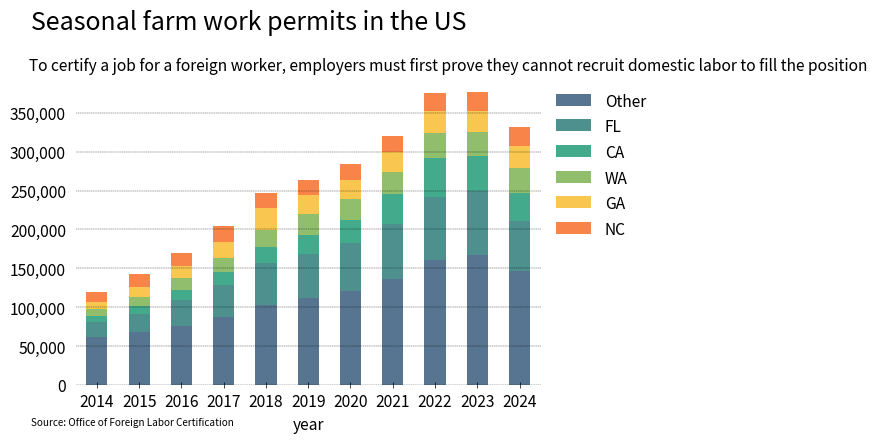

In [36]:
# Draw the chart, with titles and styling

big5.plot(x='year', kind='bar',stacked=True, color=colors)

style.style_plot(plt,'Seasonal farm work permits in the US',
                 'To certify a job for a foreign worker, employers must first prove they cannot recruit domestic labor to fill the position',
                 'Office of Foreign Labor Certification')

# Move legend to right
ax = plt.subplot(111)
ax.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=0, ha='center') 

# Change Y tick format to insert commas
yticks = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(t) for t in yticks])

plt.savefig('h2apermits.svg')